In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tskit
import msprime
import demes

import sys
sys.path.append('..')
import tslmm
import tslmm.operations as operations
import tslmm.matrices as matrices
from tslmm.tslmm import TSLMM
from tslmm.simulations import sim_genetic_value

In [16]:
def simulate(sigma, tau, tree_sequence, mutation_rate, rng=None, num_covariates=0):
    """
    float sigma: non-genetic variance, i.e., residual
    float tau: genetic variance
    tskit.TreeSequence tree_sequence: tree sequence
    float mutation_rate: mutation rate (e.g. 1e-8)
    np.random.Generator rng: numpy random number generator
    np.ndarray subset: index of individuals to use # currently not an active option
    bool center_covariance: center covariance if True
    """
    if rng is None: rng = np.random.default_rng()
    X = rng.normal(size=(tree_sequence.num_individuals, num_covariates)) # covariates
    g = sim_genetic_value(tree_sequence) * np.sqrt(mutation_rate * tau) # genetic value 
    e = rng.normal(size=tree_sequence.num_individuals) * np.sqrt(sigma) # residual
    b = rng.normal(size=5) # fixed effect size
    y = g + e # trait value
    if num_covariates > 0:
        y += X @ b
    return y, X, b, g

In [17]:
# example tree sequence
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10_000)
demography.add_population(name="B", initial_size=10_000)
demography.add_population(name="ancestral", initial_size=1_000)
demography.add_population_split(time=1000, 
                                derived=["A", "B"],
                                ancestral="ancestral")
seq_length = 1e6
ts = msprime.sim_ancestry(samples={"A":1000, "B":1000},
                          sequence_length=seq_length,
                          recombination_rate=1e-8,
                          demography=demography,
                          ploidy=2,
                          random_seed=1)

varcov = 1, 3
mu = 1e-10
rng = np.random.default_rng()
traits, covariates, fixef, genetic_values = simulate(*varcov, ts, mu, rng=rng)

In [18]:
# initialize tslmm object
subset = np.arange(0, ts.num_individuals, 2)
lmm = TSLMM(ts, mu, traits[subset], covariates[subset], phenotyped_individuals=subset, rng=rng)

# fit variance component
lmm.fit_variance_components(method='ai', haseman_elston=True, verbose=True)

Iteration 0: [0.97 2.74], 95.97788758349382
Iteration 1: [0.93 2.85], 50.133844712354566
Iteration 2: [0.91 2.88], 24.92154061496234
Iteration 3: [0.9  2.92], 12.335906648775154
Iteration 4: [0.9  2.95], 6.47765894701671
Iteration 5: [0.9  2.92], 2.3249860898943826
Iteration 6: [0.9  2.93], 1.7320170824443712
Iteration 7: [0.9  2.91], 4.334194956100363
Iteration 8: [0.9  2.92], 4.259980355730676
Iteration 9: [0.9  2.93], 5.347046068017009
Iteration 10: [0.9  2.94], 2.7085649775932796
Iteration 11: [0.9  2.95], 4.420770704633562
Iteration 12: [0.9  2.93], 3.2365925138843146
Iteration 13: [0.9  2.93], 0.16687732334157226
Iteration 14: [0.9 2.9], 3.15406306712467
Iteration 15: [0.9  2.92], 2.26369294219012
Iteration 16: [0.9  2.94], 1.1468240952260507
Final variance component values: [0.8983 2.9246]


In [4]:
# genomic prediction - should fit VC prior to prediction
# blups: prediction (posterior mean)
# var_blups: posterior variance
# it predicts the values for *all* individuals (both phenotyped and not phenotyped)
blups, var_blups = lmm.predict(np.arange(ts.num_individuals), variance_samples=100)

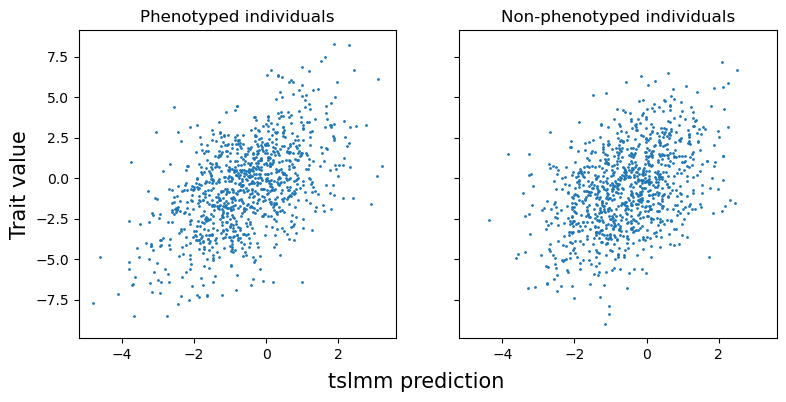

In [5]:
# main scatterplots
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
not_subset = np.setdiff1d(np.arange(ts.num_individuals), subset) # non-phenotyped individuals
ax[0].scatter(blups[subset], traits[subset], s=1)
ax[1].scatter(blups[not_subset], traits[not_subset], s=1)

# annotation
ax[0].set_ylabel('Trait value', fontsize=15)
fig.text(0.5, 0, 'tslmm prediction', fontsize=15, ha='center', va='center')
ax[0].set_title('Phenotyped individuals')
ax[1].set_title('Non-phenotyped individuals')

plt.show()